In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

from qat.qpus import get_default_qpu
from qat.core import Batch, Job

from qat.fermion.transforms import transform_to_jw_basis
from qat.fermion.hamiltonians import make_embedded_model
from qat.fermion.circuits import make_shallow_circ, make_ldca_circ

from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.trotterisation import make_trotterisation_routine
from qat.fermion.chemistry.ucc import construct_ucc_ansatz, guess_init_params, get_hf_ket, get_cluster_ops
from qat.qpus import get_default_qpu

from qat.plugins import ScipyMinimizePlugin, MultipleLaunchesAnalyzer

In [2]:
from openvqe.common_files import molecule_factory

In [3]:
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 0.7414))]
basis = "sto-3g"
spin = 0
charge = 0

(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_electrons,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True)

print(
    f" HF energy :  {info['HF']}\n",
    f"MP2 energy : {info['MP2']}\n",
    f"FCI energy : {info['FCI']}\n",
)
print(f"Number of qubits before active space selection = {rdm1.shape[0] * 2}")

nqbits = rdm1.shape[0] * 2
print("Number of qubits = ", nqbits)

/home/huybinh/.local/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


 HF energy :  -1.1166843870853405
 MP2 energy : -1.1298551535553094
 FCI energy : -1.137270174660903

Number of qubits before active space selection = 4
Number of qubits =  4


In [4]:
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.chemistry.ucc import (
    guess_init_params,
    get_hf_ket,
    get_cluster_ops,
)

# Wrap the hamiltonian data into the `MolecularHamiltonian` class.
mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)


molecule = MoleculeInfo(hamiltonian=mol_h, n_electrons=n_electrons, noons = False,  orbital_energies=orbital_energies)
print(molecule.nqbits)

4


In [5]:
# Computation of the initial parameters
theta_init = guess_init_params(
    molecule.two_body_integrals,
    molecule.n_electrons,
    molecule.orbital_energies,
)

# Define the initial Hartree-Fock state
ket_hf_init = get_hf_ket(molecule.n_electrons, nqbits=molecule.nqbits)

# Compute the cluster operators
cluster_ops = get_cluster_ops(molecule.n_electrons, nqbits=molecule.nqbits)


# Get the ElectronicStructureHamiltonian
H = molecule.hamiltonian.get_electronic_hamiltonian()




In [6]:
from qat.fermion.transforms import transform_to_jw_basis, get_jw_code, recode_integer

transformation, code = transform_to_jw_basis, get_jw_code

H_sp = transformation(H)
model = H_sp
nqbits = model.nbqbits

# Express the cluster operator in spin terms
cluster_ops_sp = [transformation(t_o) for t_o in cluster_ops]

# Encoding the initial state to new encoding
hf_init_sp = recode_integer(ket_hf_init, code(nqbits))


print("This model has the number of qubit:", model.nbqbits)
print("The number of excitation for this model", len(cluster_ops_sp))
print(model)

This model has the number of qubit: 4
The number of excitation for this model 3
(-0.09886396933545827+0j) * I^4 +
(0.1686221915892095+0j) * (ZZ|[0, 1]) +
(0.12054482205301797+0j) * (ZZ|[0, 2]) +
(0.165867024105892+0j) * (ZZ|[1, 2]) +
(0.165867024105892+0j) * (ZZ|[0, 3]) +
(0.17119774903432972+0j) * (Z|[0]) +
(0.12054482205301797+0j) * (ZZ|[1, 3]) +
(0.17119774903432972+0j) * (Z|[1]) +
(0.045322202052874+0j) * (XYYX|[0, 1, 2, 3]) +
(-0.045322202052874+0j) * (XXYY|[0, 1, 2, 3]) +
(-0.045322202052874+0j) * (YYXX|[0, 1, 2, 3]) +
(0.045322202052874+0j) * (YXXY|[0, 1, 2, 3]) +
(0.17434844185575687+0j) * (ZZ|[2, 3]) +
(-0.22278593040418468+0j) * (Z|[2]) +
(-0.22278593040418468+0j) * (Z|[3])


In [7]:
model_matrix_sp = model.get_matrix(sparse=True)
from scipy.sparse.linalg import eigsh
eigval, eigvec = eigsh(model_matrix_sp, k=14)

print(eigval)
#print(eigvec)


[-1.13727017  0.92010672  0.71375399  0.47983612  0.35243414  0.23780528
  0.35243414 -0.44698572 -0.44698572 -0.53870958 -0.53247901 -0.53247901
 -0.53870958 -0.53247901]


In [8]:
eigvals_cl = np.linalg.eigvalsh(model.get_matrix())
E0 = min(eigvals_cl)
print(f"Exact ground state energy:\nE0 = {E0}")

Exact ground state energy:
E0 = -1.1372701746609026


In [9]:

import itertools
from typing import Any, List, Tuple, Optional, Dict
from bitstring import BitArray
import numpy as np

from qat.core import Term
from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I, X

from qat.fermion.trotterisation import make_spin_hamiltonian_trotter_slice
from qat.fermion.hamiltonians import SpinHamiltonian, FermionHamiltonian
from qat.fermion.util import tobin

def k_ucc_ansatz(
    cluster_ops: List[SpinHamiltonian],
    k: int, # number of excitations
    theta: float,  
    n_steps: int = 1,
) -> Program:


    nqbits = cluster_ops[0].nbqbits

    prog = Program()
    reg = prog.qalloc(nqbits)

    # Initialize the Hartree-Fock state into the Program
    for j, char in enumerate(tobin(k, nqbits)):
        if char == "1":
            prog.apply(X, reg[j])
        if char == "0":
            prog.apply(I, reg[j])
    

    print("This applied state is ", tobin(k, nqbits))
    # Define the parameters to optimize


    # Trotterize the Hamiltonian (with 1 trotter step)
    idx = 0
    for _ in range(n_steps):

        # Define the Hamiltonian for current Trotter step
        hamiltonian = sum([th * T for th, T in zip(theta[idx : idx + len(cluster_ops)], cluster_ops)])

        # Trotterize the Hamiltonian and apply QRoutine
        qrout = make_spin_hamiltonian_trotter_slice(hamiltonian, coeff=1.0 / n_steps)
        prog.apply(qrout, reg)

        # Take the next set (of length len(cluster_ops)) of thetas
        idx += len(cluster_ops)

    return prog.to_circ()

In [10]:
import numpy as np
n_steps =1 
prog = Program()

theta_0 = [np.random.uniform(0, 2*np.pi) for i in range(len(cluster_ops) * n_steps)]
theta = [prog.new_var(float, f"\\theta_{i}") for i in range(len(theta_0))]

print("The initial HF state ", hf_init_sp)

k_lst = [hf_init_sp, 1] # List of the excitation

def create_circuit(k):
    return k_ucc_ansatz(cluster_ops_sp, k, theta)


# Create and store circuits in a list
circuits_store = [create_circuit(k) for k in k_lst]

# Display the circuits
for circ_dis in circuits_store:
    circ_dis.display()
print(len(theta_0))
# The circuits_store[0] should be the initial HF state

The initial HF state  12
This applied state is  1100
This applied state is  0001


3


In [11]:
circuits_store[0].display()

#### Tesitng the ScipyMinimizePlugin / Minimize

In [12]:
from qat.qpus import get_default_qpu
from qat.plugins import ScipyMinimizePlugin
import scipy
from scipy.optimize import minimize

qpu = get_default_qpu()

optimizer_scipy = ScipyMinimizePlugin(method="BFGS", tol=1e-3, options={"maxiter": 1000, "disp": True}, x0=theta_0)
stack = optimizer_scipy | qpu
res_theta = stack.submit(circuits_store[0].to_job(job_type="OBS", observable=model))

# Define termms for the measurments
xlist_U = res_theta.value
ylist_U = res_theta.meta_data["parameters"]
vals_U = res_theta.meta_data["optimization_trace"]
trace_U = eval(vals_U)
data_U =  res_theta.meta_data["optimizer_data"]

print("Optimization energy Result:", xlist_U)
print("The optimization data:", data_U)
print("Theta optimization updated", ylist_U)
print("Evaluated energy for each optimized step",trace_U)
print(vals_U)

Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 11
         Function evaluations: 52
         Gradient evaluations: 13
Optimization energy Result: -1.1372701742719817
The optimization data:   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.1372701742719817
        x: [ 1.571e+00  1.571e+00  1.684e+00]
      nit: 11
      jac: [ 4.172e-07 -3.381e-05  5.275e-06]
 hess_inv: [[ 6.390e-01 -1.408e-01 -2.521e-03]
            [-1.408e-01  7.007e-01 -9.696e-04]
            [-2.521e-03 -9.696e-04  3.091e-01]]
     nfev: 52
     njev: 13
Theta optimization updated [1.5708018310079541, 1.5707735965196663, 1.6838660941802253]
Evaluated energy for each optimized step [-0.18505478008056456, -0.1850547871137195, -0.185054769400663, -0.1850547850833811, -0.4109655475481473, -0.410965533268439, -0.4109655478930021, -0.4109655381164161, -0.8027871028248483, -0.8027870970755853, -0.802787099628764, -0.802787097

In [13]:
#Storing information

iterations = {
    "minimum_energy_result": [],
    "theta_optimized_result": [],
    "energy_optimized_result": [],
}



iterations["minimum_energy_result"].append(xlist_U) 
iterations["theta_optimized_result"].append(ylist_U)
iterations["energy_optimized_result"].append(trace_U)

print(iterations)

{'minimum_energy_result': [-1.1372701742719817], 'theta_optimized_result': ['[1.5708018310079541, 1.5707735965196663, 1.6838660941802253]'], 'energy_optimized_result': [[-0.18505478008056456, -0.1850547871137195, -0.185054769400663, -0.1850547850833811, -0.4109655475481473, -0.410965533268439, -0.4109655478930021, -0.4109655381164161, -0.8027871028248483, -0.8027870970755853, -0.802787099628764, -0.8027870976385276, -0.5290002618855315, -0.5290002723096172, -0.5290002700090165, -0.5290002568251589, -0.8899943271420382, -0.8899943293508912, -0.8899943271943237, -0.8899943233912218, -0.9449930343279644, -0.9449930417587216, -0.9449930293674056, -0.9449930378155678, -0.9847391309190737, -0.9847391373017758, -0.9847391276120104, -0.9847391412262236, -1.0520101173051586, -1.0520101232168828, -1.0520101150994492, -1.0520101236778538, -1.1334176780334926, -1.1334176794596655, -1.133417677736643, -1.1334176788964996, -1.1372354891771637, -1.1372354891864083, -1.1372354890539418, -1.13723548930

In [14]:

opt_circ_U = circuits_store[0].bind_variables(eval(res_theta.meta_data["parameter_map"]))
print(eval(res_theta.meta_data["parameter_map"]))

{'\\theta_0': 1.5708018310079541, '\\theta_1': 1.5707735965196663, '\\theta_2': 1.6838660941802253}


Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 11
         Function evaluations: 52
         Gradient evaluations: 13


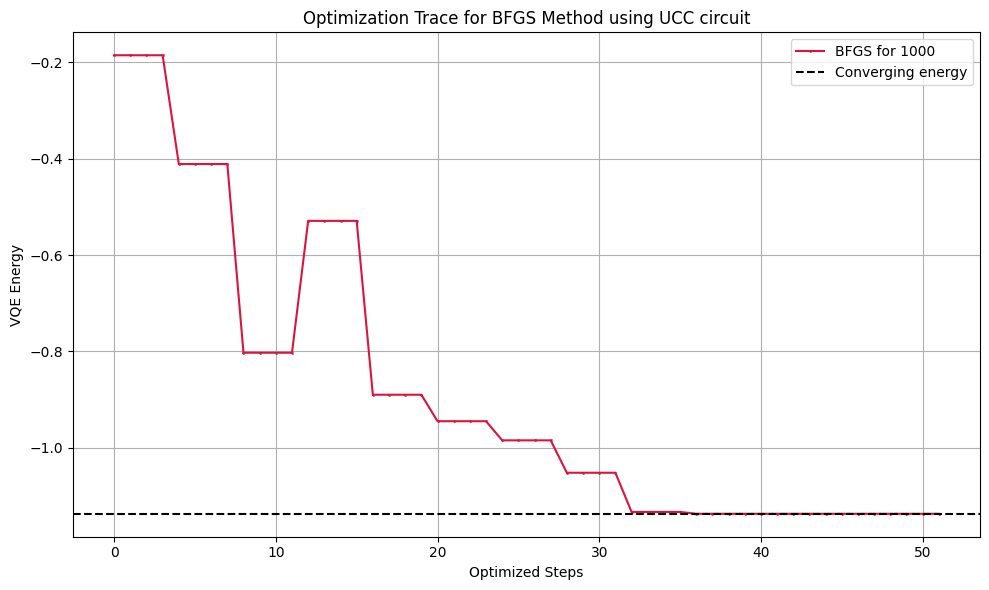

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming stack, job_theta, and job_funct are already defined

# Plot the optimization trace for BFGS from job_theta
res_theta = stack.submit(circuits_store[0].to_job(job_type="OBS", observable=model))
vals_U = res_theta.meta_data["optimization_trace"]
trace_U = eval(vals_U)
#trace_U = trace_U[:3500] 3

xlist_U = res_theta.value

plt.figure(figsize=(10, 6))

# Plot the trace_U
plt.plot(
    trace_U,
    lw=1.5,
    label="BFGS for 1000",
    color='crimson',
    linestyle='solid',
    marker='3',
    markersize=2.2
)


plt.axhline(xlist_U, color='black', linestyle='--', label="Converging energy")

plt.xlabel("Optimized Steps")
plt.ylabel("VQE Energy")
plt.legend()
plt.grid(True)
plt.title("Optimization Trace for BFGS Method using UCC circuit")
plt.tight_layout()
plt.show()

In [16]:
from qat.qpus import get_default_qpu
from qat.plugins import ScipyMinimizePlugin
import scipy
from scipy.optimize import minimize

qpu = get_default_qpu()

optimizer_scipy = ScipyMinimizePlugin(method="BFGS", tol=1e-3, options={"maxiter": 1000, "disp": True}, x0=theta_0)
stack = optimizer_scipy | qpu
res_theta = stack.submit(circuits_store[0].to_job(job_type="OBS", observable=model))
xlist_U = res_theta.value

Optimizer = scipy.optimize.minimize(
            lambda theta: xlist_U,
            x0= theta_0,
            method= "BFGS",
            tol=1e-3,
            options={"maxiter": 1000, "disp": True})
print(Optimizer)

Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 11
         Function evaluations: 52
         Gradient evaluations: 13
Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 0
         Function evaluations: 4
         Gradient evaluations: 1
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.1372701742680806
        x: [ 1.012e+00  3.178e+00  2.157e+00]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00]
 hess_inv: [[1 0 0]
            [0 1 0]
            [0 0 1]]
     nfev: 4
     njev: 1


In [17]:
print(Optimizer.x)

[1.01207405 3.17831696 2.15707262]


In [18]:
opt_circ_ground = circuits_store[0].bind_variables({k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)})
#print(opt_circ_ground)
theta_star = {k: v for k, v in zip(sorted(circuits_store[0].get_variables()), Optimizer.x)}
print("List of the update theta", theta_star)

List of the update theta {'\\theta_0': 1.0120740500611978, '\\theta_1': 3.178316960935049, '\\theta_2': 2.1570726224513854}


In [19]:
opt_circ_U = circuits_store[0].bind_variables(eval(res_theta.meta_data["parameter_map"]))
job_opt_U = opt_circ_U.to_job()
from qat.qpus import get_default_qpu

# Evaluate the job and print the output probabilities
result = get_default_qpu().submit(job_opt_U)
nbqbits = model.nbqbits

#for sample in result:
#    print(sample.state, sample.state.int, sample.amplitude, sample.probability)

def get_statevector(result, nbqbits):
    """
    Get the statevector from the Result class

    Parameters
    -----------
    result: qat.core.BatchResult
        the result of an executed job
    
    nbqbits: int
        the number of qubits
    
    statevector: ndarray
        the resulting statevector representation

    """
    statevector = np.zeros((2**nbqbits), np.complex128)
    for sample in result:
        statevector[sample.state.int] = sample.amplitude
    return statevector

#a = get_statevector(result, nbqbits)
#print(a)


"""|0010> 2 (0.1128309460151194+0j) 0.012730822378666786
|0100> 4 (2.2972878152272576e-06+0j) 5.277531305991626e-12
|1000> 8 (-0.9936141995840929+0j) 0.9872691776151377
|1110> 14 (9.55580326644776e-07+0j) 9.13133760670537e-13
[ 0.00000000e+00+0.j  0.00000000e+00+0.j  1.12830946e-01+0.j
  0.00000000e+00+0.j  2.29728782e-06+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j  0.00000000e+00+0.j -9.93614200e-01+0.j
  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j  0.00000000e+00+0.j  9.55580327e-07+0.j
  0.00000000e+00+0.j]"""

'|0010> 2 (0.1128309460151194+0j) 0.012730822378666786\n|0100> 4 (2.2972878152272576e-06+0j) 5.277531305991626e-12\n|1000> 8 (-0.9936141995840929+0j) 0.9872691776151377\n|1110> 14 (9.55580326644776e-07+0j) 9.13133760670537e-13\n[ 0.00000000e+00+0.j  0.00000000e+00+0.j  1.12830946e-01+0.j\n  0.00000000e+00+0.j  2.29728782e-06+0.j  0.00000000e+00+0.j\n  0.00000000e+00+0.j  0.00000000e+00+0.j -9.93614200e-01+0.j\n  0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j\n  0.00000000e+00+0.j  0.00000000e+00+0.j  9.55580327e-07+0.j\n  0.00000000e+00+0.j]'

In [20]:
job_opt_ground = opt_circ_ground.to_job()


# Evaluate the job and print the output probabilities
result = get_default_qpu().submit(job_opt_ground)
nbqbits = model.nbqbits

ground_stv= get_statevector(result, nbqbits)
print(ground_stv)

[ 0.        +0.j  0.        +0.j  0.        +0.j  0.45850635+0.j
  0.        +0.j  0.        +0.j  0.0194633 +0.j  0.        +0.j
  0.        +0.j -0.8473614 +0.j  0.        +0.j  0.        +0.j
  0.26715494+0.j  0.        +0.j  0.        +0.j  0.        +0.j]


In [24]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from numpy import binary_repr
from qat.qpus import get_default_qpu

qpu = get_default_qpu()
method = "BFGS"


model = H_sp
def overlap(def_stv, eigenvector):
    overlap_vals = abs(np.vdot(def_stv, eigenvector)) ** 2
    return overlap_vals

def_stv =  ground_stv

energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}
nqbits = 4

def opt_funct(circuits, model, qpu, nqbits, def_stv, energy_lists, beta):
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            result = qpu.submit(bound_circ.to_job(observable=model))
            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)
            exci_stv = get_statevector(result, nqbits)
            overlap_inp = overlap(def_stv, exci_stv) 

        

            total_energy = energy + beta[i]*overlap_inp
        return total_energy

    def callback(x):
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            result = qpu.submit(bound_circ.to_job(observable=model))
            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)
            exci_stv = get_statevector(result, nqbits)
            overlap_inp = overlap(def_stv, exci_stv) 

    return input_funct, callback

beta = [3]
circuits = circuits_store[1]
input_funct, callback = opt_funct(circuits, model, qpu, nqbits, def_stv, energy_lists, beta)
options = {"disp": True, "maxiter": 3500, "gtol": 1e-7}
Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method=method, callback=callback, options=options)


NameError: name 'bind_variables' is not defined

#### What we have now is the 
- The expectation value for the ground state 
- The expectation value for the 1st state
- 

Optimization terminated successfully.
         Current function value: -1.137270
         Iterations: 9
         Function evaluations: 56
         Gradient evaluations: 14


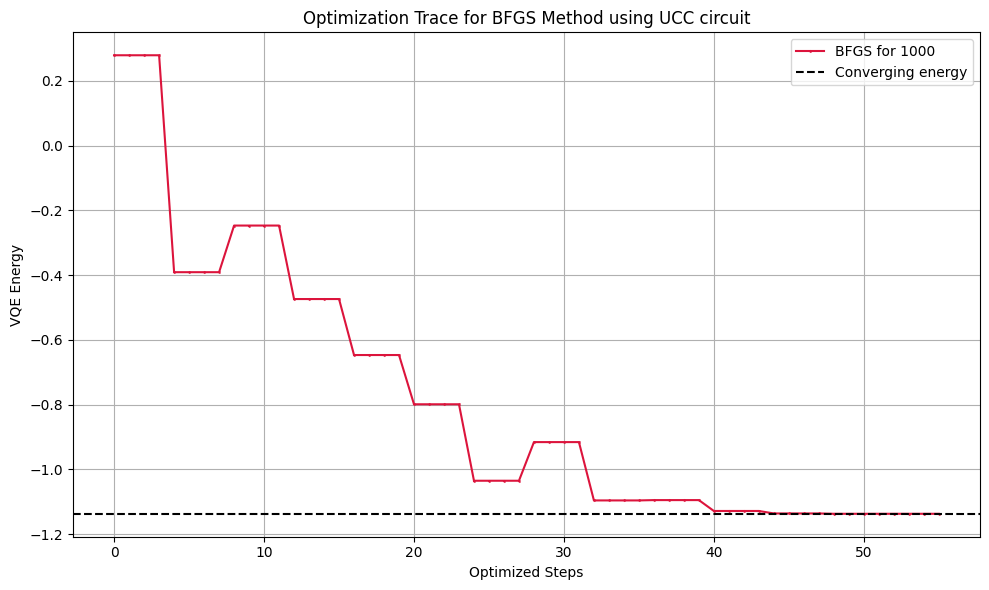

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming stack, job_theta, and job_funct are already defined

# Plot the optimization trace for BFGS from job_theta
res_theta = stack.submit(circuits_store[0].to_job(job_type="OBS", observable=model))
vals_U = res_theta.meta_data["optimization_trace"]
trace_U = eval(vals_U)
#trace_U = trace_U[:3500] 3

xlist_U = res_theta.value

plt.figure(figsize=(10, 6))

# Plot the trace_U
plt.plot(
    trace_U,
    lw=1.5,
    label="BFGS for 1000",
    color='crimson',
    linestyle='solid',
    marker='3',
    markersize=2.2
)


plt.axhline(xlist_U, color='black', linestyle='--', label="Converging energy")

plt.xlabel("Optimized Steps")
plt.ylabel("VQE Energy")
plt.legend()
plt.grid(True)
plt.title("Optimization Trace for BFGS Method using UCC circuit")
plt.tight_layout()
plt.show()

#### Tesitng the ScipyMinimize

In [ ]:
opt_circ_exci_target =circuits_store[0].bind_variables(zip(sorted(circuits_store[0].get_variables())))

AttributeError: 'zip' object has no attribute 'keys'

#### Play with two type of Optimizer Plugin

In [ ]:
import numpy
from qat.vsolve.optimize import ScipyMinimizePlugin
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qat.qpus import get_default_qpu

methods = ["COBYLA", "Nelder-Mead", "BFGS"]

Optimizer = ScipyMinimizePlugin( method="BFGS", 
                                 x0 = theta,
                                 tol=1e-6,
                                 options={"maxiter": 200, "disp": True},
                                 )


"""   
# Here again initial parameters are randomly chosen and a list of method can be used in the future 
methods = ["COBYLA", "BFGS", "PSO", "SPSA"]
plugins = {
    "COBYLA": ScipyMinimizePlugin(method="COBYLA", x0=x0),
    "BFGS": ScipyMinimizePlugin(method="BFGS", x0=x0),
    "PSO": PSOMinimizePlugin(),
    "SPSA": SPSAMinimizePlugin(x0=x0),
}
for method in methods:
    stack = plugins[method] | qpu
    res[method] = stack.submit(circ.to_job(job_type="OBS", observable=obs))

"""


qpu = get_default_qpu()
stack = Optimizer | qpu


job_theta = circuits_store[0].to_job(job_type="OBS",
                  observable=model,
                  nbshots=0)

res_theta = stack.submit(job_theta)
# Define termms for the measurments
xlist_U = res_theta.value
ylist_U = res_theta.meta_data["parameters"]
vals_U = res_theta.meta_data["optimization_trace"]
trace_U = eval(vals_U)
data_U =  res_theta.meta_data["optimizer_data"]

print("Optimization energy Result:", xlist_U)
print("The optimization data:", data_U)
print("Theta optimization updated", ylist_U)
print("Evaluated energy for each optimized step",trace_U)
print(vals_U)

PluginException: PluginException(code=None, modulename='qat.plugins.junction', message='Caught exception from junction: "float() argument must be a string or a real number, not \'Variable\'" [see /tmp/tmpmbgqk01r.junction.log for traceback info]', file=None, line=None)

In [ ]:
# To write circuits
from qat.lang.AQASM import *
from qat.lang import Program
# To define an observable
from qat.core import Observable, Term
# our Plugin
from qat.plugins import ObservableSplitter
# and a QPU
from qat.qpus import get_default_qpu
from qat.interop.qiskit import qlm_to_qiskit

Box State: 0000, Value: 0, Excitation: 0.7137539936876182
Box State: 0001, Value: 1, Excitation: 0.23780527846665372
Box State: 0010, Value: 2, Excitation: 0.23780527846665367
Box State: 0100, Value: 4, Excitation: -0.5387095798772803
Box State: 1000, Value: 8, Excitation: -0.5387095798772803
Box State: 0011, Value: 3, Excitation: 0.459250330668717
Box State: 0101, Value: 5, Excitation: -0.5324790068861727
Box State: 1001, Value: 9, Excitation: -0.3511901986746766
Box State: 0110, Value: 6, Excitation: -0.3511901986746766
Box State: 1010, Value: 10, Excitation: -0.5324790068861727
Box State: 1100, Value: 12, Excitation: -1.1166843870853407
Box State: 0111, Value: 7, Excitation: 0.3524341417394585
Box State: 1011, Value: 11, Excitation: 0.3524341417394585
Box State: 1101, Value: 13, Excitation: -0.4469857176706651
Box State: 1110, Value: 14, Excitation: -0.4469857176706651
Box State: 1111, Value: 15, Excitation: 0.920106719167038


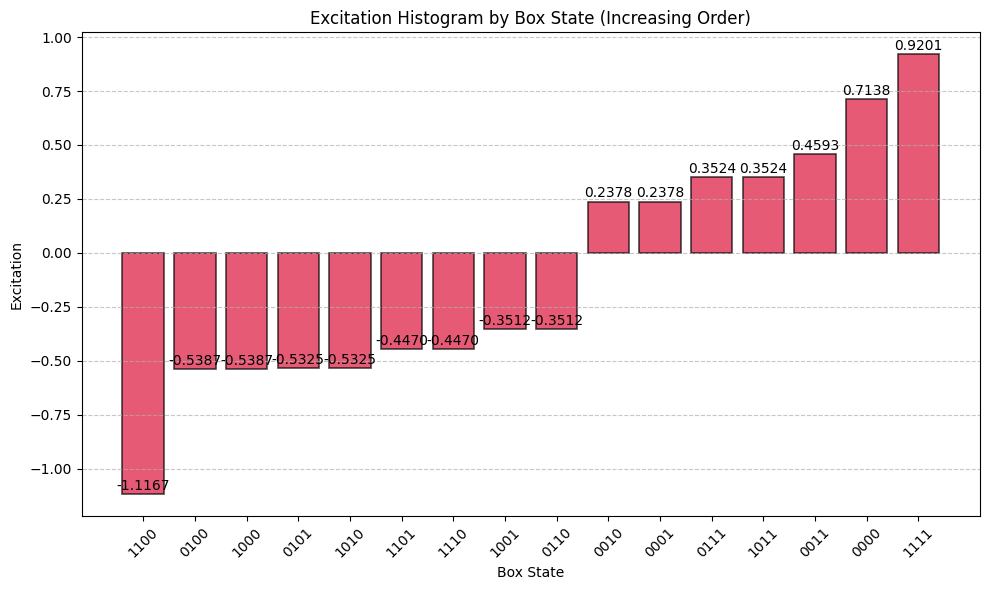

In [ ]:
import matplotlib.pyplot as plt
from numpy import binary_repr
from qat.lang import Program, X
from qat.qpus import get_default_qpu

# Assuming hamiltonian_sp is defined somewhere in your code
# and box_list contains the values you mentioned
box_list = [0, 1, 2, 4, 8, 3, 5, 9, 6, 10, 12, 7, 11, 13, 14, 15]


def create_program(value, nqbits):
    ket_value = binary_repr(value)
    padded_ket_value = ket_value.zfill(nqbits)  # Pad with zeros to the left
    list_ket_value = [int(c) for c in padded_ket_value]

    prog = Program()
    qb = prog.qalloc(nqbits)

    # Apply X gates based on the binary representation of the current value
    for j in range(min(nqbits, len(list_ket_value))):
        if list_ket_value[j] == 1:
            prog.apply(X, qb[j])

    return prog


excitation_values = []
box_states = []

for value in box_list:
    nqbits = model.nbqbits
    prog = create_program(value, nqbits)

    circ = prog.to_circ()
    qpu = get_default_qpu()

    # Assuming hamiltonian_sp is defined somewhere in your code
    job = circ.to_job(job_type="OBS", observable=model)
    res = qpu.submit(job)

    box_states.append(binary_repr(value, width=nqbits))
    excitation_values.append(res.value)

    # Print the box state and the result for each value
    print(f"Box State: {binary_repr(value, width=nqbits)}, Value: {value}, Excitation: {res.value}")

# Sorting the data by excitation values
sorted_data = sorted(zip(box_states, excitation_values), key=lambda x: x[1])

# Extracting sorted box states and excitation values
sorted_box_states, sorted_excitation_values = zip(*sorted_data)

# Plotting histogram with a larger figure size, crimson color, and a different style
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
bars = plt.bar(sorted_box_states, sorted_excitation_values, color='crimson', alpha=0.7, edgecolor='black', linestyle='-', linewidth=1.2)
plt.xlabel('Box State')
plt.ylabel('Excitation')
plt.title('Excitation Histogram by Box State (Increasing Order)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text annotations on top of each bar
for bar, excitation in zip(bars, sorted_excitation_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{excitation:.4f}', ha='center', va='bottom')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

From this graph, I decided the three exact values 
-  Ground state 1100 with k=12 
- The first excited state 0100 with k=4 
- The second excited state 1101 with k=13
- The third excited state 0110 with k= 6

#### Step 1: Draw the circuit $U(\theta)$

This circuit is get inspiration the fact that instead of the CNOT we have the Z control gate 

In [ ]:
from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings

In [ ]:
#With initial state
def U_theta(
    nqbits: int,
    theta: List[float],
    k_init: int,
    n_layers: int = 1,
    rotation_gates: List[Gate] = None,
    entangling_gate: Gate = CNOT,
) -> Circuit: #linear entanglement

    prog = Program()
    reg = prog.qalloc(nqbits)
    
    
    state = binary_repr(k_init)
    state_pad = state.zfill(nqbits)
    state_lst = [int(c) for c in state_pad]


    for j in range(min(nqbits, len(state_lst))):
        if int(state_lst[j] == 1):
            prog.apply(X, reg[j])
        
        if int(state_lst[j] == 0):
            prog.apply(I, reg[j])
    
    print("This initial state is ", state_pad)
    
    
    
    
    if rotation_gates is None:
        rotation_gates = [RZ]

    n_rotations = len(rotation_gates)

    
    
    ind_theta = 0


    
    for i in range(nqbits):

        for rot in rotation_gates:

            prog.apply(rot(theta[ind_theta]), reg[i])
            ind_theta += 1
    
    for k in range(n_layers):


        for i in range(nqbits - 1):
            prog.apply(CNOT, reg[i], reg[i+1])
            
        for i in range(nqbits):
            for rot in rotation_gates:
                            
                prog.apply(rot(theta[ind_theta]), reg[i])
                ind_theta += 1
    

    return prog.to_circ()

In [ ]:
import numpy as np
n_rotations = 2
nqbits =4
n_layers = 3


theta_0 = [np.random.uniform(0, 2*np.pi) for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_layers))]
k_lst = [12,4,13]
theta = [prog.new_var(float, rf"\theta_{{{i}}}") for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_layers))]

#Circuit implementation with applied state
circ_ground = U_theta(4, theta, 12, 3, [RX,RZ], CNOT)
circ_ground.display()

circ_exci_1 = U_theta(4, theta, 4, 3, [RX,RZ], CNOT)
circ_exci_1.display()

circ_exci_2 = U_theta(4, theta, 13, 3, [RX,RZ], CNOT)
circ_exci_2.display()

circ_exci_3 = U_theta(4, theta, 6, 3, [RX,RZ], CNOT)
circ_exci_3.display()



This initial state is  1100


This initial state is  0100


This initial state is  1101


This initial state is  0110


2B: Test with compact version

In [ ]:
import scipy
import numpy as np
from qat.vsolve.optimize import ScipyMinimizePlugin
from qat.qpus import get_default_qpu
import matplotlib.pyplot as plt
import scipy.optimize as sp_optimize


def opt_funct(circ_funct_ground_input, circ_funct_exci_1_input, circ_funct_exci_2_input, model, qpu, nqbits, energy_circ_ground, energy_circ_exci_1, energy_circ_exci_2):
    def input_funct(x):
        opt_circ_ground = circ_funct_ground_input.bind_variables({k: v for k, v in zip(sorted(circ_funct_ground_input.get_variables()), x)})
        opt_circ_exci_1 = circ_funct_exci_1_input.bind_variables({k: v for k, v in zip(sorted(circ_funct_exci_1_input.get_variables()), x)})
        opt_circ_exci_2 = circ_funct_exci_2_input.bind_variables({k: v for k, v in zip(sorted(circ_funct_exci_2_input.get_variables()), x)})
        
        stack0 = qpu.submit(opt_circ_ground.to_job(observable=model))
        stack1 = qpu.submit(opt_circ_exci_1.to_job(observable=model))
        stack2 = qpu.submit(opt_circ_exci_2.to_job(observable=model))

        
        energy_ground = stack0.value
        energy_exci_1 = stack1.value
        energy_exci_2 = stack2.value


        energy_circ_ground[method].append(energy_ground)
        energy_circ_exci_1[method].append(energy_exci_1)
        energy_circ_exci_2[method].append(energy_exci_2)


        energy_cost =  5*energy_ground + 2*energy_exci_1 +  0.3*energy_exci_2 
        return energy_cost

    def callback(x):
        opt_circ_ground = circ_funct_ground_input.bind_variables({k: v for k, v in zip(sorted(circ_funct_ground_input.get_variables()), x)})
        opt_circ_exci_1 = circ_funct_exci_1_input.bind_variables({k: v for k, v in zip(sorted(circ_funct_exci_1_input.get_variables()), x)})
        opt_circ_exci_2 = circ_funct_exci_2_input.bind_variables({k: v for k, v in zip(sorted(circ_funct_exci_2_input.get_variables()), x)})

        
        stack0 = qpu.submit(opt_circ_ground.to_job(observable=model))
        stack1 = qpu.submit(opt_circ_exci_1.to_job(observable=model))
        stack2 = qpu.submit(opt_circ_exci_2.to_job(observable=model))

        
        energy_ground = stack0.value
        energy_exci_1 = stack1.value
        energy_exci_2 = stack2.value


        energy_circ_ground[method].append(energy_ground)
        energy_circ_exci_1[method].append(energy_exci_1)
        energy_circ_exci_2[method].append(energy_exci_2)
    #This one is not necessary

    return input_funct, callback

# Initialize the QPU
qpu = get_default_qpu()

# Set the method
method = "BFGS"



# Initialize energy dictionaries
energy_circ_ground = {method: []}
energy_circ_exci_1 = {method: []}
energy_circ_exci_2 = {method: []}




input_funct,callback = opt_funct(circ_ground, circ_exci_1, circ_exci_2, model, qpu, nqbits, energy_circ_ground, energy_circ_exci_1, energy_circ_exci_2)
options = {"disp": True, "maxiter": 500, "gtol": 1e-7}


Optimizer = scipy.optimize.minimize(input_funct, x0=theta_0, method = "BFGS", callback=callback)


In [ ]:
print(Optimizer.x)

[ 2.31420121e-07  1.57079683e+00  6.28318515e+00  6.28318853e+00
  1.57079676e+00  3.59667773e+00  1.57079647e+00  2.95611804e+00
  3.72481078e+00  1.57079640e+00 -2.61896895e-02  5.57656348e+00
  3.25496972e+00  1.57075042e+00  4.71238381e+00  4.71243342e+00
  6.28318542e+00  2.62499858e+00 -1.07925459e-07 -2.48317079e-01
  1.57079563e+00  1.52106648e+00  1.57079769e+00  3.25496959e+00
  6.15122271e+00  3.14159369e+00  1.57079960e+00  3.14159281e+00
  4.71238933e+00  4.71238932e+00  3.14159320e+00  4.52504856e+00
  1.61852693e+00  2.30648212e+00  2.17741434e+00  3.83524735e+00
  2.27184727e+00  2.84547621e+00  1.61583814e+00  2.95102134e+00
  4.56216586e+00  4.00061131e+00  1.37925166e-01  2.11165732e+00]


In [ ]:
print(len(Optimizer.x))
print(len(Optimizer.x))

44
44


In [ ]:
opt_circ_ground = circ_ground.bind_variables({k: v for k, v in zip(sorted(circ_ground.get_variables()), Optimizer.x)})
#print(opt_circ_ground)
print({k: v for k, v in zip(sorted(circ_ground.get_variables()), Optimizer.x)})


{'\\theta_{0}': 2.3142012141255974e-07, '\\theta_{10}': 1.5707968273267738, '\\theta_{11}': 6.283185154083226, '\\theta_{12}': 6.283188530652374, '\\theta_{13}': 1.5707967617927283, '\\theta_{14}': 3.596677732177228, '\\theta_{15}': 1.5707964717286766, '\\theta_{16}': 2.956118037592041, '\\theta_{17}': 3.7248107755809223, '\\theta_{18}': 1.5707964030414812, '\\theta_{19}': -0.026189689466070105, '\\theta_{1}': 5.576563475769327, '\\theta_{20}': 3.254969724910243, '\\theta_{21}': 1.5707504153669773, '\\theta_{22}': 4.712383807938466, '\\theta_{23}': 4.712433418601531, '\\theta_{24}': 6.283185417844854, '\\theta_{25}': 2.6249985777787543, '\\theta_{26}': -1.0792545892552207e-07, '\\theta_{27}': -0.2483170790599244, '\\theta_{28}': 1.5707956260237368, '\\theta_{29}': 1.5210664841806887, '\\theta_{2}': 1.570797690809373, '\\theta_{30}': 3.254969593492511, '\\theta_{31}': 6.151222711997157, '\\theta_{3}': 3.1415936885893783, '\\theta_{4}': 1.5707995982587435, '\\theta_{5}': 3.14159281021757

In [ ]:
from qat.qpus import get_default_qpu
qpu = get_default_qpu()
job = opt_circ_ground.to_job(job_type="OBS", observable=model, nbshots=0)
resultnew = qpu.submit(job)
print("Minimum VQE energy =", resultnew.value)

Minimum VQE energy = -1.136601848091659


In [ ]:
opt_circ_exci_1 = circ_exci_1.bind_variables({k: v for k, v in zip(sorted(circ_exci_1.get_variables()), Optimizer.x)})
#print(opt_circ_ground)
print({k: v for k, v in zip(sorted(circ_exci_1.get_variables()), Optimizer.x)})


{'\\theta_{0}': 2.3142012141255974e-07, '\\theta_{10}': 1.5707968273267738, '\\theta_{11}': 6.283185154083226, '\\theta_{12}': 6.283188530652374, '\\theta_{13}': 1.5707967617927283, '\\theta_{14}': 3.596677732177228, '\\theta_{15}': 1.5707964717286766, '\\theta_{16}': 2.956118037592041, '\\theta_{17}': 3.7248107755809223, '\\theta_{18}': 1.5707964030414812, '\\theta_{19}': -0.026189689466070105, '\\theta_{1}': 5.576563475769327, '\\theta_{20}': 3.254969724910243, '\\theta_{21}': 1.5707504153669773, '\\theta_{22}': 4.712383807938466, '\\theta_{23}': 4.712433418601531, '\\theta_{24}': 6.283185417844854, '\\theta_{25}': 2.6249985777787543, '\\theta_{26}': -1.0792545892552207e-07, '\\theta_{27}': -0.2483170790599244, '\\theta_{28}': 1.5707956260237368, '\\theta_{29}': 1.5210664841806887, '\\theta_{2}': 1.570797690809373, '\\theta_{30}': 3.254969593492511, '\\theta_{31}': 6.151222711997157, '\\theta_{3}': 3.1415936885893783, '\\theta_{4}': 1.5707995982587435, '\\theta_{5}': 3.14159281021757

In [ ]:
from qat.qpus import get_default_qpu
qpu = get_default_qpu()
job = opt_circ_exci_1.to_job(job_type="OBS", observable=model, nbshots=0)
resultnew = qpu.submit(job)
print("Minimum VQE energy =", resultnew.value)

Minimum VQE energy = -0.5310675037993631


In [ ]:
opt_circ_exci_2 = circ_exci_2.bind_variables({k: v for k, v in zip(sorted(circ_exci_1.get_variables()), Optimizer.x)})
#print(opt_circ_ground)
print({k: v for k, v in zip(sorted(circ_exci_2.get_variables()), Optimizer.x)})



{'\\theta_{0}': 2.3142012141255974e-07, '\\theta_{10}': 1.5707968273267738, '\\theta_{11}': 6.283185154083226, '\\theta_{12}': 6.283188530652374, '\\theta_{13}': 1.5707967617927283, '\\theta_{14}': 3.596677732177228, '\\theta_{15}': 1.5707964717286766, '\\theta_{16}': 2.956118037592041, '\\theta_{17}': 3.7248107755809223, '\\theta_{18}': 1.5707964030414812, '\\theta_{19}': -0.026189689466070105, '\\theta_{1}': 5.576563475769327, '\\theta_{20}': 3.254969724910243, '\\theta_{21}': 1.5707504153669773, '\\theta_{22}': 4.712383807938466, '\\theta_{23}': 4.712433418601531, '\\theta_{24}': 6.283185417844854, '\\theta_{25}': 2.6249985777787543, '\\theta_{26}': -1.0792545892552207e-07, '\\theta_{27}': -0.2483170790599244, '\\theta_{28}': 1.5707956260237368, '\\theta_{29}': 1.5210664841806887, '\\theta_{2}': 1.570797690809373, '\\theta_{30}': 3.254969593492511, '\\theta_{31}': 6.151222711997157, '\\theta_{3}': 3.1415936885893783, '\\theta_{4}': 1.5707995982587435, '\\theta_{5}': 3.14159281021757

In [ ]:


theta_update = {k: v for k, v in zip(sorted(circ_exci_2.get_variables()), Optimizer.x)}
print(theta_update)

{'\\theta_{0}': 2.3142012141255974e-07, '\\theta_{10}': 1.5707968273267738, '\\theta_{11}': 6.283185154083226, '\\theta_{12}': 6.283188530652374, '\\theta_{13}': 1.5707967617927283, '\\theta_{14}': 3.596677732177228, '\\theta_{15}': 1.5707964717286766, '\\theta_{16}': 2.956118037592041, '\\theta_{17}': 3.7248107755809223, '\\theta_{18}': 1.5707964030414812, '\\theta_{19}': -0.026189689466070105, '\\theta_{1}': 5.576563475769327, '\\theta_{20}': 3.254969724910243, '\\theta_{21}': 1.5707504153669773, '\\theta_{22}': 4.712383807938466, '\\theta_{23}': 4.712433418601531, '\\theta_{24}': 6.283185417844854, '\\theta_{25}': 2.6249985777787543, '\\theta_{26}': -1.0792545892552207e-07, '\\theta_{27}': -0.2483170790599244, '\\theta_{28}': 1.5707956260237368, '\\theta_{29}': 1.5210664841806887, '\\theta_{2}': 1.570797690809373, '\\theta_{30}': 3.254969593492511, '\\theta_{31}': 6.151222711997157, '\\theta_{3}': 3.1415936885893783, '\\theta_{4}': 1.5707995982587435, '\\theta_{5}': 3.14159281021757

In [ ]:
from qat.qpus import get_default_qpu
qpu = get_default_qpu()
job = opt_circ_exci_2.to_job(job_type="OBS", observable=model, nbshots=0)
resultnew = qpu.submit(job)
print("Minimum VQE energy =", resultnew.value)

Minimum VQE energy = -0.5324790068822522


In [ ]:
def V_phi(
    nqbits: int,
    phi: List[float],
    n_cycles: int = 1,
    k_targ: int=1,
    rotation_gates: List[Gate] = None,
    entangling_gate: Gate = CNOT,
) -> Circuit:
    prog = Program()
    reg = prog.qalloc(nqbits)
    
    state = binary_repr(k_targ)
    state_pad = state.zfill(nqbits)
    state_lst = [int(c) for c in state_pad]

    for j in range(min(nqbits, len(state_lst))):
        if int(state_lst[j] == 1):
            prog.apply(X, reg[j])
        if int(state_lst[j] == 0):
            prog.apply(I, reg[j])
    
    print("This targer state is ", state_pad)

    if rotation_gates is None:
        rotation_gates = [RZ]

    n_rotations = len(rotation_gates)

    ind_phi = 0

    for k in range(n_cycles):


        # Apply rotational gates from qubit nqbits//2 to nqbits - 1
        for i in range(nqbits//2, nqbits):
            for rot in rotation_gates:
                prog.apply(rot(phi[ind_phi]), reg[i])
                ind_phi += 1

        # Apply CNOT gates from qubit nqbits//2 to nqbits - 2
        for i in range(nqbits//2, nqbits - 1):
            prog.apply(entangling_gate, reg[i], reg[i + 1])

        # Reset ind_phi for the next cycle
        ind_phi = 0

    return prog.to_circ()

In [ ]:
n_rotations = 2
nqbits =4
n_cycles = 3
k_targ = 6
phi = [prog.new_var(float, rf"\phi_{{{i}}}") for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_cycles))]
phi_0 = [np.random.uniform(0, 2*np.pi) for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_cycles))]
print("Values that will be distribute to all the indicator of phi as applied state are :", phi_0)

circ_phi = V_phi(4, phi, 3, 5, [RX,RZ], CNOT)
circ_phi.display()

Values that will be distribute to all the indicator of phi as applied state are : [4.9084494470922815, 3.9720254757866074, 2.9158378691147555, 3.0940437915194696, 3.319927865878691, 2.9157051275380144, 3.6666677238598573, 3.239550485631347, 0.13772851879887665, 3.199710787477587, 4.201231439004502, 3.2781764957698036, 4.932874307125693, 5.506644014434147, 3.5815701459588394, 1.556367028948745, 4.255419761358624, 0.9073919333571866, 2.0589379442877513, 3.3148872386951775, 3.5172880933315187, 5.303104835812712, 5.289325342686889, 4.8727241184512, 0.44492400874073545, 3.709715439566421, 0.6963951897586151, 3.775202810691833, 5.073574486877298, 2.035874931462908, 4.598549879565499, 3.754780804595752, 3.6338905469757212, 3.2092912796384914, 1.9526553575855714, 1.0697066528186634, 1.5200042424296345, 0.88236498289241, 1.243657359767585, 3.976283666999609, 2.9757674938089673, 4.219929499383319, 2.4812309383517848, 5.00046706843143]
This targer state is  0101


In [ ]:
def U_theta(
    nqbits,
    theta,
    k_init,
    n_layers,
    rotation_gates,
    entangling_gate: Gate = CNOT,
) -> Circuit: #linear entanglement
    prog = Program()
    reg = prog.qalloc(nqbits)
    state = binary_repr(k_init)
    state_pad = state.zfill(nqbits)
    state_lst = [int(c) for c in state_pad]
    for j in range(min(nqbits, len(state_lst))):
        if int(state_lst[j] == 1):
            prog.apply(X, reg[j])
        if int(state_lst[j] == 0):
            prog.apply(I, reg[j])
    print("This initial state is ", state_pad)
    if rotation_gates is None:
        rotation_gates = [RZ]
    n_rotations = len(rotation_gates)
    ind_theta = 0
    for i in range(nqbits):
        for rot in rotation_gates:
            prog.apply(rot(theta[ind_theta]), reg[i])
            ind_theta += 1
    for k in range(n_layers):
        for i in range(nqbits - 1):
            prog.apply(CNOT, reg[i], reg[i+1])
        for i in range(nqbits):
            for rot in rotation_gates:
                prog.apply(rot(theta[ind_theta]), reg[i])
                ind_theta += 1
    return prog.to_circ()

n_rotations = 2
nqbits = 4
n_cycles =3 # this is for V
n_layers = 3
theta = [prog.new_var(float, rf"\theta_{{{i}}}") for i in range(n_rotations * (nqbits + 2 * (nqbits - 1) * n_layers))]
print(theta)
circ_U = U_theta(4, theta, 0, 3, [RX,RZ], CNOT)
circ_U.display()
print(len(theta))

print(len(Optimizer.x))
circuitU_statr = circ_U.bind_variables({k: v for k, v in zip(sorted(circ_U.get_variables()), Optimizer.x)})

[<qat.core.variables.Variable object at 0x7fd6b38f7460>, <qat.core.variables.Variable object at 0x7fd6b38f7400>, <qat.core.variables.Variable object at 0x7fd6b38f72b0>, <qat.core.variables.Variable object at 0x7fd6b38f7250>, <qat.core.variables.Variable object at 0x7fd6b38f71f0>, <qat.core.variables.Variable object at 0x7fd6b38f7190>, <qat.core.variables.Variable object at 0x7fd6b38f7130>, <qat.core.variables.Variable object at 0x7fd6b38f70d0>, <qat.core.variables.Variable object at 0x7fd6b38f7070>, <qat.core.variables.Variable object at 0x7fd6b38f7010>, <qat.core.variables.Variable object at 0x7fd6b38f6fb0>, <qat.core.variables.Variable object at 0x7fd6b38f6f50>, <qat.core.variables.Variable object at 0x7fd6b38f6ef0>, <qat.core.variables.Variable object at 0x7fd6b38f6e90>, <qat.core.variables.Variable object at 0x7fd6b38f6e30>, <qat.core.variables.Variable object at 0x7fd6b38f6dd0>, <qat.core.variables.Variable object at 0x7fd6b38f6d70>, <qat.core.variables.Variable object at 0x7fd6b3

44
44


In [ ]:
from numpy import binary_repr
total_circuit = circ_phi + circuitU_statr
total_circuit.display()

In [ ]:
import scipy
import numpy as np
from qat.vsolve.optimize import ScipyMinimizePlugin
from qat.qpus import get_default_qpu
import matplotlib.pyplot as plt
import scipy.optimize as sp_optimize


def opt_funct(circ_funct_ground_target, model, qpu, nqbits,energy_circ_exci_target):
    def input_funct(x):
        opt_circ_exci_target =circ_funct_ground_target.bind_variables({k: v for k, v in zip(sorted(circ_funct_ground_target.get_variables()), x)})
        
        stack3 = qpu.submit(opt_circ_exci_target.to_job(observable=model))

        
        energy_exci_target = stack3.value


        energy_circ_exci_target[method].append(energy_exci_target)


        energy_cost =  -1*energy_exci_target
        return energy_cost

    def callback(x):
        opt_circ_exci_target = circ_funct_ground_target.bind_variables({k: v for k, v in zip(sorted(circ_funct_ground_target.get_variables()), x)})
        
        stack3 = qpu.submit(opt_circ_exci_target.to_job(observable=model))

        
        energy_exci_target = stack3.value
        energy_circ_exci_target[method].append(energy_exci_target)

    #This one is not necessary

    return input_funct, callback

# Initialize the QPU
qpu = get_default_qpu()

# Set the method
method = "BFGS"
# Initialize energy dictionaries
energy_circ_exci_target = {method: []}


input_funct,callback = opt_funct(total_circuit, model, qpu, nqbits,energy_circ_exci_target)

options = {"disp": True, "maxiter": 2000, "gtol": 1e-10}

Optimizer = scipy.optimize.minimize(input_funct, x0=phi_0, method = "BFGS", callback=callback)

In [ ]:
print(Optimizer)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.47916779167502654
        x: [ 3.142e+00  3.810e+00 ...  2.481e+00  5.000e+00]
      nit: 9
      jac: [ 2.682e-07  2.980e-08 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 1.948e+00  1.967e-01 ...  2.016e-06  2.017e-06]
            [ 1.967e-01  8.986e-01 ...  6.471e-07  6.493e-07]
            ...
            [ 2.016e-06  6.471e-07 ...  1.000e+00 -2.079e-10]
            [ 2.017e-06  6.493e-07 ... -2.079e-10  1.000e+00]]
     nfev: 540
     njev: 12


In [ ]:
energy_circ_exci_target[method][-2]

0.47916779167502654

In [ ]:
-0.5387095797454402
-0.5412111548195652
-0.5387095796472738
-1.1285380263879896


[-1.13727017  0.92010672  0.71375399  0.47983612  0.35243414  0.35243414
 -0.44698572 -0.44698572 -0.53870958 -0.53247901 -0.53247901 -0.53870958
 -0.53247901]

Box State: 0000, Value: 0, Excitation: 0.7137539936876182
Box State: 0001, Value: 1, Excitation: 0.23780527846665372
Box State: 0010, Value: 2, Excitation: 0.23780527846665367
Box State: 0100, Value: 4, Excitation: -0.5387095798772803
Box State: 1000, Value: 8, Excitation: -0.5387095798772803
Box State: 0011, Value: 3, Excitation: 0.459250330668717
Box State: 0101, Value: 5, Excitation: -0.5324790068861727
Box State: 1001, Value: 9, Excitation: -0.3511901986746766
Box State: 0110, Value: 6, Excitation: -0.3511901986746766
Box State: 1010, Value: 10, Excitation: -0.5324790068861727
Box State: 1100, Value: 12, Excitation: -1.1166843870853407
Box State: 0111, Value: 7, Excitation: 0.3524341417394585
Box State: 1011, Value: 11, Excitation: 0.3524341417394585
Box State: 1101, Value: 13, Excitation: -0.4469857176706651
Box State: 1110, Value: 14, Excitation: -0.4469857176706651
Box State: 1111, Value: 15, Excitation: 0.920106719167038


SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (3530024745.py, line 12)